# <font color=blue> Real Time Flight Data Streaming - Spark Structured Streaming Classification </font>
**Author:**  Armin Berger

In this task, we implemented Spark Structured Streaming to consume the data from task 1 and perform streaming classification. The ML model seeks to determine whether a flight will be delayed or not.

## Step 1

#### Initialize Spark Session

SparkSession is created using a SparkConf object, which would use two local cores
with a proper application name, and use UTC as the timezone 3.

In [1]:
# load in all required libraries
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql import SparkSession
from pyspark import SparkConf 
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.types import *


# set up the spark configuartion
spark_conf = SparkConf()\
.setMaster('local[2]')\
.set('spark.sql.session.timeZone', 'UTC')

# start the spark session
spark = SparkSession \
    .builder \
    .config(conf=spark_conf) \
    .appName("Flight Data Streaming") \
    .getOrCreate() 
sc = spark.sparkContext
sc.setLogLevel('ERROR')


ModuleNotFoundError: No module named 'pyspark'

In [2]:
# import libraries needed from this project
# from pyspark import SparkConf
# from pyspark import SparkContext
# from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType, IntegerType, ArrayType
from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
#from pyspark.ml.classification import NaiveBayes 
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

import math 
import statistics as stat
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import time

ModuleNotFoundError: No module named 'pyspark'

## Step 2

#### Connection to Kafka Producer

From the Kafka producers in Task 1, ingest the streaming data into Spark Streaming.

In [3]:
# set up the topic for this session
topic = 'flightTopic'

# read the stream sent by the producer
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic) \
    .load()

In [4]:
# printing the schema of the data stream
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



## Step 3 

#### Setting schema

Then the streaming data format should be transformed into the proper formats following the file schema in the metadata.

In [5]:
# converting the key, value kafka data stream to string format
df = df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [6]:
# define a schema in accordance with the original flight data schema
flight_schema = ArrayType(StructType([    
    StructField('YEAR', StringType(), False),
    StructField('MONTH', StringType(), False),
    StructField('DAY', StringType(), False),
    StructField('DAY_OF_WEEK', StringType(), False),
    StructField('AIRLINE', StringType(), False),
    StructField('FLIGHT_NUMBER', StringType(), False),
    StructField('TAIL_NUMBER', StringType(), False),
    StructField('ORIGIN_AIRPORT', StringType(), False),
    StructField('DESTINATION_AIRPORT', StringType(), False),
    StructField('SCHEDULED_DEPARTURE', StringType(), False),
    StructField('DEPARTURE_TIME', StringType(), False),
    StructField('DEPARTURE_DELAY', StringType(), False),
    StructField('TAXI_OUT', StringType(), False),
    StructField('WHEELS_OFF', StringType(), False),
    StructField('SCHEDULED_TIME', StringType(), False),
    StructField('ELAPSED_TIME', StringType(), False),
    StructField('AIR_TIME', StringType(), False),
    StructField('DISTANCE', StringType(), False),
    StructField('WHEELS_ON', StringType(), False),
    StructField('TAXI_IN', StringType(), False),
    StructField('SCHEDULED_ARRIVAL', StringType(), False),
    StructField('ARRIVAL_TIME', StringType(), False),
    StructField('ARRIVAL_DELAY', StringType(), False),
    StructField('DIVERTED', StringType(), False),
    StructField('CANCELLED', StringType(), False),
    StructField('CANCELLATION_REASON', StringType(), False),
    StructField('AIR_SYSTEM_DELAY', StringType(), False),
    StructField('SECURITY_DELAY', StringType(), False),
    StructField('AIRLINE_DELAY', StringType(), False),
    StructField('LATE_AIRCRAFT_DELAY', StringType(), False),
    StructField('WEATHER_DELAY', StringType(), False),
    StructField('ts', StringType(), True) 
    ]))

In [7]:
# use the from_json function to parse the string to the json format based on the defined schema
df = df.select(F.from_json(F.col("value").cast("string"), flight_schema).alias('parsed_value'))

# we explode the column parsed_value 
df = df.select(F.explode(F.col("parsed_value")).alias('unnested_value'))  

# after exploding the columns we give them their original titles for easier processing
df_formatted = df.select(
                    F.col("unnested_value.YEAR").alias("YEAR"),
                    F.col("unnested_value.MONTH").alias("MONTH"),
                    F.col("unnested_value.DAY").alias("DAY"),
                    F.col("unnested_value.DAY_OF_WEEK").alias("DAY_OF_WEEK"),
                    F.col("unnested_value.AIRLINE").alias("AIRLINE"),
                    F.col("unnested_value.FLIGHT_NUMBER").alias("FLIGHT_NUMBER"),
                    F.col("unnested_value.TAIL_NUMBER").alias("TAIL_NUMBER"),
                    F.col("unnested_value.ORIGIN_AIRPORT").alias("ORIGIN_AIRPORT"),
                    F.col("unnested_value.DESTINATION_AIRPORT").alias("DESTINATION_AIRPORT"),
                    F.col("unnested_value.SCHEDULED_DEPARTURE").alias("SCHEDULED_DEPARTURE"),
                    F.col("unnested_value.DEPARTURE_TIME").alias("DEPARTURE_TIME"),
                    F.col("unnested_value.DEPARTURE_DELAY").alias("DEPARTURE_DELAY"),
                    F.col("unnested_value.TAXI_OUT").alias("TAXI_OUT"),
                    F.col("unnested_value.WHEELS_OFF").alias("WHEELS_OFF"),
                    F.col("unnested_value.SCHEDULED_TIME").alias("SCHEDULED_TIME"),
                    F.col("unnested_value.ELAPSED_TIME").alias("ELAPSED_TIME"),
                    F.col("unnested_value.AIR_TIME").alias("AIR_TIME"),
                    F.col("unnested_value.DISTANCE").alias("DISTANCE"),
                    F.col("unnested_value.WHEELS_ON").alias("WHEELS_ON"),
                    F.col("unnested_value.TAXI_IN").alias("TAXI_IN"),
                    F.col("unnested_value.SCHEDULED_ARRIVAL").alias("SCHEDULED_ARRIVAL"),
                    F.col("unnested_value.ARRIVAL_TIME").alias("ARRIVAL_TIME"),
                    F.col("unnested_value.ARRIVAL_DELAY").alias("ARRIVAL_DELAY"),
                    F.col("unnested_value.DIVERTED").alias("DIVERTED"),
                    F.col("unnested_value.CANCELLED").alias("CANCELLED"),
                    F.col("unnested_value.CANCELLATION_REASON").alias("CANCELLATION_REASON"),
                    F.col("unnested_value.AIR_SYSTEM_DELAY").alias("AIR_SYSTEM_DELAY"),
                    F.col("unnested_value.SECURITY_DELAY").alias("SECURITY_DELAY"),
                    F.col("unnested_value.AIRLINE_DELAY").alias("AIRLINE_DELAY"),
                    F.col("unnested_value.LATE_AIRCRAFT_DELAY").alias("LATE_AIRCRAFT_DELAY"),
                    F.col("unnested_value.WEATHER_DELAY").alias("WEATHER_DELAY"),
                    F.col("unnested_value.ts").alias("ts")
                )


In [8]:
# check the schema of the new file
df_formatted.printSchema()

root
 |-- YEAR: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- DAY: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: string (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: string (nullable = true)
 |-- DEPARTURE_TIME: string (nullable = true)
 |-- DEPARTURE_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- SCHEDULED_TIME: string (nullable = true)
 |-- ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- SCHEDULED_ARRIVAL: string (nullable = true)
 |-- ARRIVAL_TIME: string (nullable = true)
 |-- ARRIVAL_DELAY: string (nullable = true)
 |-- D

In [9]:
# save all columns that should be in int format
int_cols = ['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'FLIGHT_NUMBER',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY',
 'ts']

In [10]:
# loop through all column names in int_cols
for col_name in int_cols:
    
    # cast all required columns to int 
    df_formatted = df_formatted.withColumn(col_name, col(col_name).cast('int'))

In [11]:
# check the schema of the new file
df_formatted.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

## Step 4 

#### Store data in parquet format

Persist the transformed streaming data in parquet format for flight data. Flight data
should be stored in “flight.parquet” in the same folder of your notebook.

In [12]:
# write into parquet files
# write data frame into parquet file format as flight_df and save it in folder flight.parquet
query_file_sink = df_formatted.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "flight.parquet/flight_df")\
        .option("checkpointLocation", "flight.parquet/flight_df/checkpoint")\
        .start()


# set a timer for 6 min, so that 6 min worth of data are written to the file    
t = 360

# code for this was taken from geeksforgeeks.org
# on the 16/10/2021
# link: https://www.geeksforgeeks.org/how-to-create-a-countdown-timer-using-python/

# loop through t until it's at
while t:
    
    # save input 
    mins, secs = divmod(t, 60)
    
    # create timer
    timer = '{:02d}:{:02d}'.format(mins, secs)
    
    # print time left
    print(timer, end="\r")
    
    # set timer to sleep for 1 sec
    time.sleep(1)
    
    # reduce time counter by one second
    t -= 1

print('stop writing to file ')

stop writing to file 


In [13]:
# stop the writing of the file into the file sink
query_file_sink.stop()

In [14]:
# after creating and writing to the parquet file we read the file in again
flight_df = spark.read.parquet("flight.parquet/flight_df")

In [15]:
# check the schema of the read in parquet file
flight_df.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

In [16]:
# check the count
flight_df.count()

6707

In [17]:
# show header of the read in df
flight_df.show(5)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+----------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|        ts|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+-

## Step 5

#### Deploy Machine Learning Models 

Load the machine learning models given, and use the models to classify whether each flight records are delayed. This is based on the assumption that the data has been
labelled.


For this step I used the models I created previously. We train and test a total of four models. We have two targets, Arrival Delay and Departure Delay, and two types of models, a Decision Tree and a Gradient Boosting tree. 

### In order to train the models and make predictions a number of data preprocessing steps were required.

In [18]:
# list of columns deemed to be not useful for our models
removed_columns = ['CANCELLATION_REASON','AIR_SYSTEM_DELAY','SECURITY_DELAY',
                     'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']

In [19]:
# create a function that removes unwated columns
def eliminate_columns(removed_columns, df):
    
    # drop the unwated columns
    df = df.drop(*removed_columns)
    
    # return the modified dataframe
    return df

In [20]:
# apply the function that removes unwated columns
flightsRawDf = eliminate_columns(removed_columns, flight_df)

In [21]:
# drop rows with na values
flightsDf = flightsRawDf.na.drop("any")

# drop rows with null values
flightsDf = flightsDf.dropna("any")

In [22]:
# label each flight as either not delayed or delayed
def return_label(data):
    
    val_return = None
    
    # condition for a flight being late
    if data > 5:
        
        val_return = 1
    
    # condition for a flight being early
    elif data <= 5:
        
        val_return = 0
    
    # return binary label 
    return val_return

In [23]:
# register the function as UDF
return_label_udf = udf(return_label,IntegerType())

In [24]:
# apply the function to the data frame and create two new columns for the binary labels
flightsDf = flightsDf\
.withColumn('binaryDeptDelay', return_label_udf('DEPARTURE_DELAY'))\
.withColumn('binaryArrDelay', return_label_udf('ARRIVAL_DELAY'))

In [25]:
# list of columns used for the ML models
nums_cols = ['MONTH',
            'DAY',
            'DAY_OF_WEEK',
            'FLIGHT_NUMBER',
            'SCHEDULED_DEPARTURE',
            'DEPARTURE_TIME',
            'DEPARTURE_DELAY',
            'TAXI_OUT',
            'WHEELS_OFF',
            'SCHEDULED_TIME',
            'ELAPSED_TIME',
            'AIR_TIME',
            'DISTANCE',
            'WHEELS_ON',
            'TAXI_IN',
            'SCHEDULED_ARRIVAL',
            'ARRIVAL_TIME',
            'ARRIVAL_DELAY',
            'ts',
            'binaryDeptDelay',
            'binaryArrDelay']

In [26]:
# subselect the required data
my_data = flightsDf.select(*nums_cols)

In [27]:
# columns that are in string format and need to be vectorized
str_cols = ['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

In [28]:
# get new column names for the indexing
str_cols_names_index = [x + '_index' for x in str_cols]

In [29]:
# configure index function
df_indexer = StringIndexer(inputCols = str_cols, outputCols = str_cols_names_index)

In [30]:
# get new column names for the vectors
output_cols_ohe = [x + '_vec' for x in str_cols]

In [31]:
# set inputs and outputs
df_encoder = OneHotEncoder(inputCols = str_cols_names_index, outputCols = output_cols_ohe)

In [32]:
# vector columns
vec_cols = ['AIRLINE_vec', 'TAIL_NUMBER_vec', 'ORIGIN_AIRPORT_vec','DESTINATION_AIRPORT_vec']

### After data preprocessing is done we now train our four models on the above processed data.

In [33]:
# create a total of four models, 2 for each target and 2 for each type of model

# decision tree models
dt_bin_dept = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'binaryDeptDelay', maxDepth = 3)
dt_bin_arr = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'binaryArrDelay', maxDepth = 3)

# gradient boost tree models
gbt_bin_dept = GBTClassifier(featuresCol="features", labelCol="binaryDeptDelay", maxIter = 3)
gbt_bin_arr = GBTClassifier(featuresCol="features", labelCol="binaryArrDelay", maxIter = 3)

In [34]:
# combine all the feature columns used for training and testing the models
input_cols = nums_cols + vec_cols

# remove the target columns
input_cols.remove('binaryDeptDelay')
input_cols.remove('binaryArrDelay')
input_cols.remove('DEPARTURE_DELAY')
input_cols.remove('ARRIVAL_DELAY')

In [35]:
# create a vector assembler, used for training and testing the models 
assembler = VectorAssembler(inputCols = input_cols, outputCol = "features")

In [36]:
# create a pipline to perform df_indexer, df_encoder,df_encoder_2, assembler all in one go
pipeline = Pipeline(stages = [df_indexer, df_encoder, assembler])

# fit and transform the bank dataframe
engineered = pipeline.fit(flightsDf).transform(flightsDf)

In [37]:
# splitting the data into testing and training
# 80 % training and 20 % testing
train, test = engineered.randomSplit([0.8, 0.2])

Train all four models on the training data.

In [38]:
%%time 
# model 1 decision tree and arrival delay
dt_bin_arr_model = dt_bin_arr.fit(train)

CPU times: user 5.79 ms, sys: 9.42 ms, total: 15.2 ms
Wall time: 7.06 s


In [39]:
%%time 
# model 2 decision tree and departure delay
dt_bin_dept_model = dt_bin_dept.fit(train)

CPU times: user 10.6 ms, sys: 2.87 ms, total: 13.5 ms
Wall time: 3.93 s


In [40]:
%%time 
# model 3 gradient boost tree and arrival delay
gbt_bin_arr_model = gbt_bin_arr.fit(train)

CPU times: user 14.1 ms, sys: 2.63 ms, total: 16.7 ms
Wall time: 6.52 s


In [41]:
%%time 
# model 4 gradient boost tree and departure delay
gbt_bin_dept_model = gbt_bin_dept.fit(train)

CPU times: user 11 ms, sys: 4.97 ms, total: 16 ms
Wall time: 5.43 s


Make predictions for all four models using the test data.

In [42]:
# make predictions with all four models for all four labels 
dt_arr_pred = dt_bin_arr_model.transform(test)
dt_dept_pred = dt_bin_dept_model.transform(test)
gbt_arr_pred = gbt_bin_arr_model.transform(test)
gbt_dept_pred = gbt_bin_dept_model.transform(test)

## Step 6

#### Model Assessment

Using the classification results, monitor the data following the requirements below.
For each key in keyFlight = ‘1’, keyFlight = ‘2’, and keyFlight = ‘3’, keep track of the accumulated accuracy for every timestamp in the 2-min window for a total of 6 minutes.

i. Your results should include, number of records flight and for each key, including their accumulated accuracy in each timestamp.

In [43]:
# function that calculates a models accumulated accuracy and flight count for each timestamp
def compute_metrics(prediction):
    
    # select the truth lables
    tup_arr = (dt_arr_pred_1, dt_arr_pred_2, dt_arr_pred_3, gbt_arr_pred_1, gbt_arr_pred_2, gbt_arr_pred_3)
    
    # define lable variable
    label = None
    
    # if truth lable is Arrival Delays
    if prediction in tup_arr:

        label = 'binaryArrDelay'
    
    # if truth lable is Departure Delays
    else:

        label = 'binaryDeptDelay'
    
    # subselect the required df columns and save them as a pd dataframe
    prediction = prediction.select('ts','prediction', label).toPandas()
    
    # save and sort all unqiue timestamps
    ts_unique = sorted(pd.unique(prediction.ts))
    
    # create a list for the accumulated accuracy of each timestamp
    acc_list = []
    
    # loop through all timestamps
    for i in range(1,len(ts_unique)): 
        
        # select all the rows in the df with matching timestamp
        row = prediction.loc[prediction.ts.isin(ts_unique[0:i]), [label, 'prediction']]
        
        # count the number of TN, TP, FN, and FP
        TN = row.loc[(row['prediction'] == 0) & (row[label] == 0),:].shape[0]
        TP = row.loc[(row['prediction'] == 1) & (row[label] == 1),:].shape[0]
        FN = row.loc[(row['prediction'] == 0) & (row[label] == 1),:].shape[0]
        FP = row.loc[(row['prediction'] == 1) & (row[label] == 0),:].shape[0]
        
        # calculate the accuracy
        accuracy = round((TN+TP)/(TN+TP+FN+FP),4)
        
        # append the timestamp, accuracy, and number of flighs
        acc_list.append((ts_unique[i-1], accuracy, row.shape[0]))
    
    # return final list
    return acc_list

In [44]:
## subselect the predictions of the four different models with different keyFlights

# Arrival Delay Decision Tree Model
dt_arr_pred_1 = dt_arr_pred.filter(dt_arr_pred.DAY_OF_WEEK == '1')
dt_arr_pred_2 = dt_arr_pred.filter(dt_arr_pred.DAY_OF_WEEK == '2')
dt_arr_pred_3 = dt_arr_pred.filter(dt_arr_pred.DAY_OF_WEEK == '3')

# Departure Delay Decision Tree Model
dt_dept_pred_1 = dt_dept_pred.filter(dt_dept_pred.DAY_OF_WEEK == '1')
dt_dept_pred_2 = dt_dept_pred.filter(dt_dept_pred.DAY_OF_WEEK == '2')
dt_dept_pred_3 = dt_dept_pred.filter(dt_dept_pred.DAY_OF_WEEK == '3')

# Arrival Delay Gradient Boosting Tree Model
gbt_arr_pred_1 = gbt_arr_pred.filter(gbt_arr_pred.DAY_OF_WEEK == '1')
gbt_arr_pred_2 = gbt_arr_pred.filter(gbt_arr_pred.DAY_OF_WEEK == '2')
gbt_arr_pred_3 = gbt_arr_pred.filter(gbt_arr_pred.DAY_OF_WEEK == '3')

# Departure Delay Gradient Boosting Tree Model
gbt_dept_pred_1 = gbt_dept_pred.filter(gbt_dept_pred.DAY_OF_WEEK == '1')
gbt_dept_pred_2 = gbt_dept_pred.filter(gbt_dept_pred.DAY_OF_WEEK == '2')
gbt_dept_pred_3 = gbt_dept_pred.filter(gbt_dept_pred.DAY_OF_WEEK == '3')


## calculate the accuracy and flight count for each of the four different models with different keyFlights

# Arrival Delay Decision Tree Model
dt_arr_pred_1_acc = compute_metrics(dt_arr_pred_1)
dt_arr_pred_2_acc = compute_metrics(dt_arr_pred_2)
dt_arr_pred_3_acc = compute_metrics(dt_arr_pred_3)

# Departure Delay Decision Tree Model
dt_dept_pred_1_acc = compute_metrics(dt_dept_pred_1)
dt_dept_pred_2_acc = compute_metrics(dt_dept_pred_2)
dt_dept_pred_3_acc = compute_metrics(dt_dept_pred_3)

# Arrival Delay Gradient Boosting Tree Model
gbt_arr_pred_1_acc = compute_metrics(gbt_arr_pred_1)
gbt_arr_pred_2_acc = compute_metrics(gbt_arr_pred_2)
gbt_arr_pred_3_acc = compute_metrics(gbt_arr_pred_3)

# Departure Delay Gradient Boosting Tree Model
gbt_dept_pred_1_acc = compute_metrics(gbt_dept_pred_1)
gbt_dept_pred_2_acc = compute_metrics(gbt_dept_pred_2)
gbt_dept_pred_3_acc = compute_metrics(gbt_dept_pred_3)

In [45]:
# for each of the four models save the accuracy and flight count in a list for later visulisation
dt_arr_pred_list = [dt_arr_pred_1_acc, dt_arr_pred_2_acc, dt_arr_pred_3_acc]
dt_dept_pred_list = [dt_dept_pred_1_acc, dt_dept_pred_2_acc, dt_dept_pred_3_acc]
gbt_arr_pred_list = [gbt_arr_pred_1_acc, gbt_arr_pred_2_acc, gbt_arr_pred_3_acc]
gbt_dept_pred_list = [gbt_dept_pred_1_acc, gbt_dept_pred_2_acc, gbt_dept_pred_3_acc]

ii. Visualise the data in line charts. Prepare a line chart plot to show the number of flights from the start to the most recent.
For this visualisation, You need two subplots. First subplot, the x-axis can be used to represent the timestamp, while y-axis can be used to represent the number of countFlightRecords. For the second subplot,
x-axis can be used to represent the timestamp, whereas y-axis can be used to plot the accumMeanAccuracy. For each subplot, the results from all keyFlights (key = ‘1’, key = ‘2’, and key = ‘3’) should be represented in different color legends.



We have a total of four models, two targets Arrival Delay and Departure Delay, and two types of models, a Decision Tree and a Gradient Boosting tree. Since we have two plots per model, one for countFlightRecords and one for accumMeanAccuracy we have a total of eight plots for this task. For each of the four model predictions we first retreive the data required and then plot it.


### Visulisations for Arrival Delay Decision Tree Model 

In [46]:
## set data for Arrival Delay Decision Tree Model

# select data for keyFlight = ‘1’
ts_x1 = list(map(lambda x: x[0],dt_arr_pred_list[0]))
acc_y1 = list(map(lambda x: x[1],dt_arr_pred_list[0]))
count_y1 = list(map(lambda x: x[2],dt_arr_pred_list[0]))

# select data for keyFlight = ‘2’
ts_x2 = list(map(lambda x: x[0],dt_arr_pred_list[1]))
acc_y2 = list(map(lambda x: x[1],dt_arr_pred_list[1]))
count_y2 = list(map(lambda x: x[2],dt_arr_pred_list[1]))

# select data for keyFlight = ‘3’
ts_x3 = list(map(lambda x: x[0],dt_arr_pred_list[2]))
acc_y3 = list(map(lambda x: x[1],dt_arr_pred_list[2]))
count_y3 = list(map(lambda x: x[2],dt_arr_pred_list[2]))

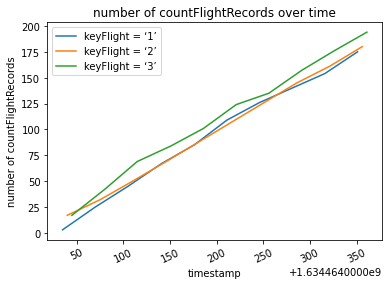

In [47]:
# plot the number of countFlightRecords for keyFlight = ‘1’
plt.plot(ts_x1, count_y1, label = "keyFlight = ‘1’")

# plot the number of countFlightRecords for keyFlight = ‘2’
plt.plot(ts_x2, count_y2, label = "keyFlight = ‘2’")

# plot the number of countFlightRecords for keyFlight = ‘3’
plt.plot(ts_x3, count_y3, label = "keyFlight = ‘3’")

# label the plot
plt.ylabel('number of countFlightRecords')
plt.xlabel('timestamp')
plt.xticks( rotation=25 )
plt.title('number of countFlightRecords over time')

# show a legend on the plot
plt.legend()

# display the plot
plt.show()

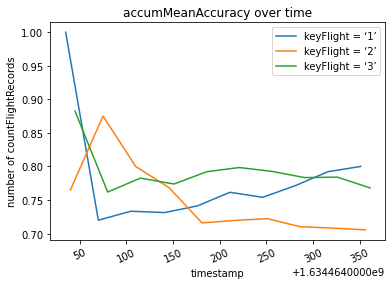

In [48]:
# plot the accumMeanAccuracy for keyFlight = ‘1’
plt.plot(ts_x1, acc_y1, label = "keyFlight = ‘1’")

# plot the accumMeanAccuracy for keyFlight = ‘2’
plt.plot(ts_x2, acc_y2, label = "keyFlight = ‘2’")

# plot the accumMeanAccuracy for keyFlight = ‘3’
plt.plot(ts_x3, acc_y3, label = "keyFlight = ‘3’")

# label the plot
plt.ylabel('number of countFlightRecords')
plt.xlabel('timestamp')
plt.xticks( rotation=25 )
plt.title('accumMeanAccuracy over time')

# show a legend on the plot
plt.legend()

# display the plot
plt.show()

### Visulisations for Departure Delay Decision Tree Model 

In [49]:
## set data for Departure Delay Decision Tree Model

# select data for keyFlight = ‘1’
ts_x1 = list(map(lambda x: x[0],dt_dept_pred_list[0]))
acc_y1 = list(map(lambda x: x[1],dt_dept_pred_list[0]))
count_y1 = list(map(lambda x: x[2],dt_dept_pred_list[0]))

# select data for keyFlight = ‘2’
ts_x2 = list(map(lambda x: x[0],dt_dept_pred_list[1]))
acc_y2 = list(map(lambda x: x[1],dt_dept_pred_list[1]))
count_y2 = list(map(lambda x: x[2],dt_dept_pred_list[1]))

# select data for keyFlight = ‘3’
ts_x3 = list(map(lambda x: x[0],dt_dept_pred_list[2]))
acc_y3 = list(map(lambda x: x[1],dt_dept_pred_list[2]))
count_y3 = list(map(lambda x: x[2],dt_dept_pred_list[2]))

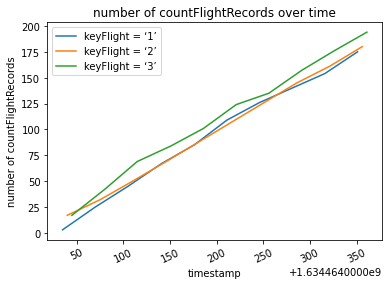

In [50]:
# plot the number of countFlightRecords for keyFlight = ‘1’
plt.plot(ts_x1, count_y1, label = "keyFlight = ‘1’")

# plot the number of countFlightRecords for keyFlight = ‘2’
plt.plot(ts_x2, count_y2, label = "keyFlight = ‘2’")

# plot the number of countFlightRecords for keyFlight = ‘3’
plt.plot(ts_x3, count_y3, label = "keyFlight = ‘3’")

# label the plot
plt.ylabel('number of countFlightRecords')
plt.xlabel('timestamp')
plt.xticks( rotation=25 )
plt.title('number of countFlightRecords over time')

# show a legend on the plot
plt.legend()

# display the plot
plt.show()

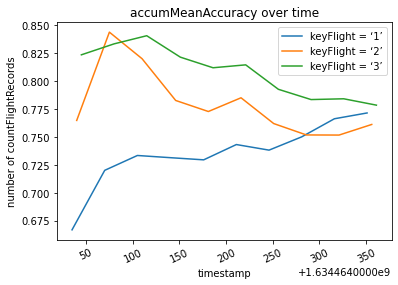

In [51]:
# plot the accumMeanAccuracy for keyFlight = ‘1’
plt.plot(ts_x1, acc_y1, label = "keyFlight = ‘1’")

# plot the accumMeanAccuracy for keyFlight = ‘2’
plt.plot(ts_x2, acc_y2, label = "keyFlight = ‘2’")

# plot the accumMeanAccuracy for keyFlight = ‘3’
plt.plot(ts_x3, acc_y3, label = "keyFlight = ‘3’")

# label the plot
plt.ylabel('number of countFlightRecords')
plt.xlabel('timestamp')
plt.xticks( rotation=25 )
plt.title('accumMeanAccuracy over time')

# show a legend on the plot
plt.legend()

# display the plot
plt.show()

### Visulisations for Arrival Delay Gradient Boosting Tree Model 

In [52]:
## set data for Arrival Delay Gradient Boosting Tree Model

# select data for keyFlight = ‘1’
ts_x1 = list(map(lambda x: x[0],gbt_arr_pred_list[0]))
acc_y1 = list(map(lambda x: x[1],gbt_arr_pred_list[0]))
count_y1 = list(map(lambda x: x[2],gbt_arr_pred_list[0]))

# select data for keyFlight = ‘2’
ts_x2 = list(map(lambda x: x[0],gbt_arr_pred_list[1]))
acc_y2 = list(map(lambda x: x[1],gbt_arr_pred_list[1]))
count_y2 = list(map(lambda x: x[2],gbt_arr_pred_list[1]))

# select data for keyFlight = ‘3’
ts_x3 = list(map(lambda x: x[0],gbt_arr_pred_list[2]))
acc_y3 = list(map(lambda x: x[1],gbt_arr_pred_list[2]))
count_y3 = list(map(lambda x: x[2],gbt_arr_pred_list[2]))

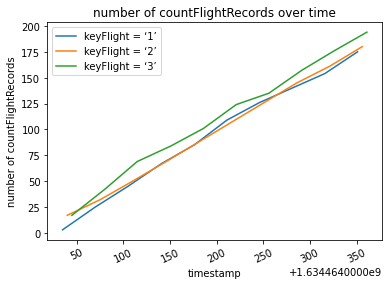

In [53]:
# plot the number of countFlightRecords for keyFlight = ‘1’
plt.plot(ts_x1, count_y1, label = "keyFlight = ‘1’")

# plot the number of countFlightRecords for keyFlight = ‘2’
plt.plot(ts_x2, count_y2, label = "keyFlight = ‘2’")

# plot the number of countFlightRecords for keyFlight = ‘3’
plt.plot(ts_x3, count_y3, label = "keyFlight = ‘3’")

# label the plot
plt.ylabel('number of countFlightRecords')
plt.xlabel('timestamp')
plt.xticks( rotation=25 )
plt.title('number of countFlightRecords over time')

# show a legend on the plot
plt.legend()

# display the plot
plt.show()

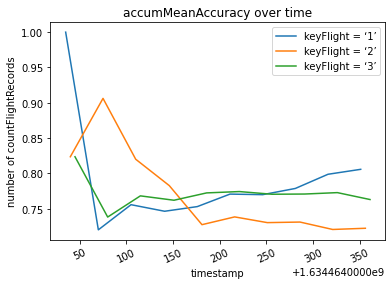

In [54]:
# plot the accumMeanAccuracy for keyFlight = ‘1’
plt.plot(ts_x1, acc_y1, label = "keyFlight = ‘1’")

# plot the accumMeanAccuracy for keyFlight = ‘2’
plt.plot(ts_x2, acc_y2, label = "keyFlight = ‘2’")

# plot the accumMeanAccuracy for keyFlight = ‘3’
plt.plot(ts_x3, acc_y3, label = "keyFlight = ‘3’")

# label the plot
plt.ylabel('number of countFlightRecords')
plt.xlabel('timestamp')
plt.xticks( rotation=25 )
plt.title('accumMeanAccuracy over time')

# show a legend on the plot
plt.legend()

# display the plot
plt.show()

### Visulisations for Departure Delay Gradient Boosting Tree Model

In [55]:
## set data for Departure Delay Gradient Boosting Tree Model

# select data for keyFlight = ‘1’
ts_x1 = list(map(lambda x: x[0],gbt_dept_pred_list[0]))
acc_y1 = list(map(lambda x: x[1],gbt_dept_pred_list[0]))
count_y1 = list(map(lambda x: x[2],gbt_dept_pred_list[0]))

# select data for keyFlight = ‘2’
ts_x2 = list(map(lambda x: x[0],gbt_dept_pred_list[1]))
acc_y2 = list(map(lambda x: x[1],gbt_dept_pred_list[1]))
count_y2 = list(map(lambda x: x[2],gbt_dept_pred_list[1]))

# select data for keyFlight = ‘3’
ts_x3 = list(map(lambda x: x[0],gbt_dept_pred_list[2]))
acc_y3 = list(map(lambda x: x[1],gbt_dept_pred_list[2]))
count_y3 = list(map(lambda x: x[2],gbt_dept_pred_list[2]))

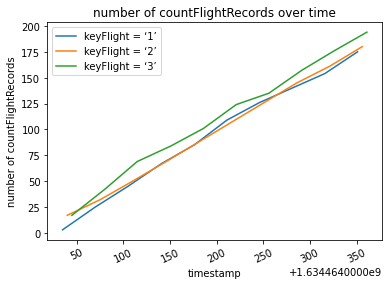

In [56]:
# plot the number of countFlightRecords for keyFlight = ‘1’
plt.plot(ts_x1, count_y1, label = "keyFlight = ‘1’")

# plot the number of countFlightRecords for keyFlight = ‘2’
plt.plot(ts_x2, count_y2, label = "keyFlight = ‘2’")

# plot the number of countFlightRecords for keyFlight = ‘3’
plt.plot(ts_x3, count_y3, label = "keyFlight = ‘3’")

# label the plot
plt.ylabel('number of countFlightRecords')
plt.xlabel('timestamp')
plt.xticks( rotation=25 )
plt.title('number of countFlightRecords over time')

# show a legend on the plot
plt.legend()

# display the plot
plt.show()

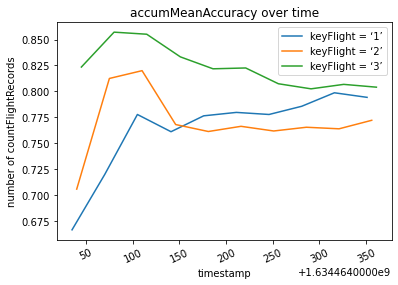

In [57]:
# plot the accumMeanAccuracy for keyFlight = ‘1’
plt.plot(ts_x1, acc_y1, label = "keyFlight = ‘1’")

# plot the accumMeanAccuracy for keyFlight = ‘2’
plt.plot(ts_x2, acc_y2, label = "keyFlight = ‘2’")

# plot the accumMeanAccuracy for keyFlight = ‘3’
plt.plot(ts_x3, acc_y3, label = "keyFlight = ‘3’")

# label the plot
plt.ylabel('number of countFlightRecords')
plt.xlabel('timestamp')
plt.xticks( rotation=25 )
plt.title('accumMeanAccuracy over time')

# show a legend on the plot
plt.legend()

# display the plot
plt.show()